# q-Dependent TDDFT 
**by <span style="color:darkgreen">Kathrin Glantschnig</span> and <span style="color:darkgreen">Ronaldo Rodrigues Pela</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> and <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**:  In this tutorial, you will learn how to set up and execute calculations to determine optical spectra within time-dependent density functional theory (**TDDFT**) for the case of non-zero momentum transfer. As example, the evolution of the loss function of silver for increasing momentum transfer in (001) direction is studied.

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Before Starting](#0)
    
[1. Ground-State Calculation](#1)
    
[2. TDDFT Calculation for Non-Zero Momentum Transfer](#2)
    
[3. Output Files](#3)
    
[4. Visualizaton](#4)
    
  - [The Effect of Intraband Contributions](#4)
        
[5. Converging the Results](#5)

[6. Evolution of the Electron Energy-Loss Function for Increasing Momentum Transfer](#6)
      
  - [Exercise](#6.1)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>


**<span style="color:firebrick">Important note:</span>** All input parameters that will appear will be given in **atomic units**!

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Ground-State Calculation</span>

First you have to create a directory to host the calculations that will be performed in this tutorial, which we **run_Ag_q_tddft**, as well as a subdirectory **q001_test_1**.

In [1]:
%%bash
mkdir -p run_Ag_q_tddft && cd run_Ag_q_tddft
mkdir -p q001_test_1
cd ..

To obtain the converged electron density and potential, needed as starting point for the TDDFT calculation, we have to perform a ground-state calculation first. For this purpose, we create the file input.xml (or copy it from a previous calculation) which should look like the following.

<span class="Ag_q_TDDFT"></span>
```xml
<input>
 
   <title>Loss function of Ag</title>
 
   <structure speciespath="$EXCITINGROOT/species">
 
      <crystal scale="7.72">
         <basevect> 0.5 0.5 0.0 </basevect>
         <basevect> 0.5 0.0 0.5 </basevect>
         <basevect> 0.0 0.5 0.5 </basevect>
      </crystal>
 
      <species speciesfile="Ag.xml">
         <atom coord="0.00 0.00 0.00" />
      </species>
 
   </structure>
 
   <groundstate
      xctype="GGA_PBE_SOL"
      ngridk="10 10 10"> 
   </groundstate>
 
</input>
```

In [2]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("03_tutorial_q_dependent_tddft", "Ag_q_TDDFT")

# Write out the input as an XML file:
with open('./run_Ag_q_tddft/q001_test_1/input.xml', "w") as fid:
    fid.write(input_str)

Do not forget to replace in the **input.xml** the actual value of the environment variable **$EXCITINGROOT**. You can do this by directly editing the **input.xml** file or by using the following command:

In [3]:
%%bash
cd run_Ag_q_tddft/q001_test_1
python3 -m excitingscripts.setup.excitingroot
cd ../..

You can start the calculation by invoking the script **`excitingscripts.execute.single`**.

In [5]:
%%bash
cd run_Ag_q_tddft
python3 -m excitingscripts.execute.single -r q001_test_1
cd ..

You can check the bunch of files created during the run, especially the main output file **INFO.OUT**, for convergence information. If the calculation of the ground state has been finished successfully, in the last lines of the **INFO.OUT** file you should find the message
    
```
...
================================================================================
| EXCITING NEON stopped                                                        =
================================================================================
```

**<span style="color:firebrick">Please note</span>**: To obtain reliable results it is necessary to perform careful convergence tests with respect to the k-point mesh (parameter <code><span style="color:mediumblue">ngridk</span></code>), the smearing width (parameter <code><span style="color:mediumblue">swidth</span></code>), and the size of the basis set (parameter <code><span style="color:mediumblue">rgkmax</span></code>). For details see the tutorial **Simple convergence tests**.

**Make sure** that your ground-state calculation is converged before you continue with the **TDDFT** calculation!

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. TDDFT Calculation for Non-Zero Momentum Transfer</span>

A well-converged groundstate is the starting point for every **TDDFT** calculation. Among the many files created during the ground-state calculation only two are essential for the **TDDFT** part, namely **EFERMI.OUT** (which contains the **<span style="color:green">Fermi level</span>**) and **STATE.OUT** (which contains the **<span style="color:green">ground-state density and potential</span>**).

**<span style="color:firebrick">Please note</span>**: If the **EFERMI.OUT** and the **STATE.OUT** files are already available from a previous calculation, it is not necessary to repeat the ground-state calculation. It can be skipped by adding the attribute <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the element <code><span style="color:green">groundstate</span></code>.

To perform a **TDDFT** calculation of the excited states, it is necessary to add the <code><span style="color:green">xs</span></code> element to the input file **input.xml**. It is placed inside the <code><span style="color:green">input</span></code> element right after the <code><span style="color:green">groundstate</span></code> element and could look like this:

```xml
...
   <xs 
      xstype="TDDFT"
      ngridk="8 8 8" 
      vkloff="0.097 0.273 0.493"
      nempty="30"
      gqmax="2.0"         
      broad="0.004"
      tevout="true">
 
      <energywindow 
         intv="0.0 2.0" 
         points="1500" />
 
      <tddft 
         fxctype="RPA"
         intraband="true"/>
 
      <qpointset>
         <qpoint> 0.0 0.0 0.00 </qpoint>
         <qpoint> 0.0 0.0 0.01 </qpoint>
      </qpointset>
 
   </xs>
...
```

In [6]:
# The following lines modify the input.xml using Python
from excitingtools import ExcitingInputXML, ExcitingXSInput

parsed_input = ExcitingInputXML.from_xml('./run_Ag_q_tddft/q001_test_1/input.xml')

xs = {'xstype': 'TDDFT',
      'ngridk': [8, 8, 8],
      'vkloff': [0.097, 0.273, 0.493],
      'nempty': 30,
      'gqmax': 2.0,
      'broad': 0.004,
      'tevout': True,
      'energywindow': {'intv': [0.0, 2.0], 'points': 1500},
      'tddft': {'fxctype': 'RPA', 'intraband': True},
      'qpointset': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.01]]}

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_Ag_q_tddft/q001_test_1/input.xml')

Within the <code><span style="color:green">xs</span></code> element one or more **q** points can be specified inside the <code><span style="color:green">qpointset</span></code> element. They are listed one after the other by using <code><span style="color:green">qpoint</span></code> elements. For a **TDDFT** calculation at non-zero momentum transfer, the **q** vector must have at least one non-zero component. The given <code><span style="color:green">xs</span></code> block corresponds to a calculation which includes local-field effects. To neglect local-field effects in the calculation, set the <code><span style="color:mediumblue">gqmax</span></code> attribute to zero. Intraband contributions are included by setting the <code><span style="color:mediumblue">intraband</span></code> attribute within the <code><span style="color:green">tddft</span></code> element to <code><span style="color:mediumblue">intraband</span>=<span style="color:firebrick">"true"</span></code>. For further information on the input parameters see **[<span style="color:firebrick">Input Reference</span>](https://www.exciting-code.org/home/about/input-reference)** and the tutorial **Excited states from TDDFT**.

**<span style="color:firebrick">Note</span>**: The **q** points are given in reciprocal space coordinates.

Now, start the **TDDFT** calculation inside the subdirectory **q001_test_1** by

In [7]:
%%bash
cd run_Ag_q_tddft
python3 -m excitingscripts.execute.single -r q001_test_1
cd ..

Information on the progress of the calculation can be found in the file **INFOXS.OUT**. Check also the **outputXS.txt** file for warnings and error messages. In **INFOXS.OUT** you will find information concerning the different tasks (each characterized by a specific task number) executed during the **TDDFT** calculation. For every task finished, you will find the following message in **INFOXS.OUT**.

```
...
================================================================================
= EXCITING NEON stopped for task    XXX                                        =
================================================================================
```
Here, **<span style="color:firebrick">XXX</span>** stands for the specific task which was carried out. As soon as task **<span style="color:firebrick">350</span>** has been completed, the complete **TDDFT** calculation is finished.

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Output Files</span>

After the **TDDFT** calculation finished successfully, optical spectra for finite momentum transfer are available from the output files listed below.

File name | Content 
:--- | :--- 
**EPSILON_<span style="color:mediumblue">xxx</span>** | dielectric function
**LOSS_<span style="color:mediumblue">xxx</span>** | loss function and dynamical structure factor
**SIGMA_<span style="color:mediumblue">xxx</span>** | optical conductivity

**<span style="color:firebrick">Note</span>**: **<span style="color:mediumblue">xxx</span>** stands for further labels present in the output file.

**LOSS_NLF_FXCRPA_QMT002.OUT** is an example of an output file containing the loss function and the dynamical structure factor. The meaning of the different labels is given below.

Label | Meaning 
:--- | :--- 
**NLF** | *no local field effects*: local-field effects were neglected in the calculation
**FXCRPA** | *xc-kernel type*: the xc-kernel used in the calculation is **RPA**
**QMT002** | *q momentum transfer*: the first q point as listed in the **QPOINTS.OUT** file was used

For further information on possible labels and their meaning see **[<span style="color:firebrick">TDDFT output files</span>](https://www.exciting-code.org/home/tddft-output-files)**.

**<span style="color:firebrick">Note</span>**: A calculation including local-field effects always gives, in addition, the spectra neglecting local-field effects.

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Visualization</span>

With the help of the python script **`excitingscripts.plot.files`** you can to visualize one or more output files of the loss function. In order to plot the data sets including and neglecting local-field effects, use the following command.

In [8]:
%%bash
cd run_Ag_q_tddft/q001_test_1
python3 -m excitingscripts.plot.files -f LOSS_FXCRPA_QMT002.OUT LOSS_NLF_FXCRPA_QMT002.OUT -lx 'Energy [eV]'  -ly 'Loss function'  -x 0 54  -y 0 1.6 -ll 'RPA (LFE)' 'RPA (no-LFE)'
cd ../..

This will generate the file **PLOT.png**, that will look like the figure below.

<figure>
<img src=" 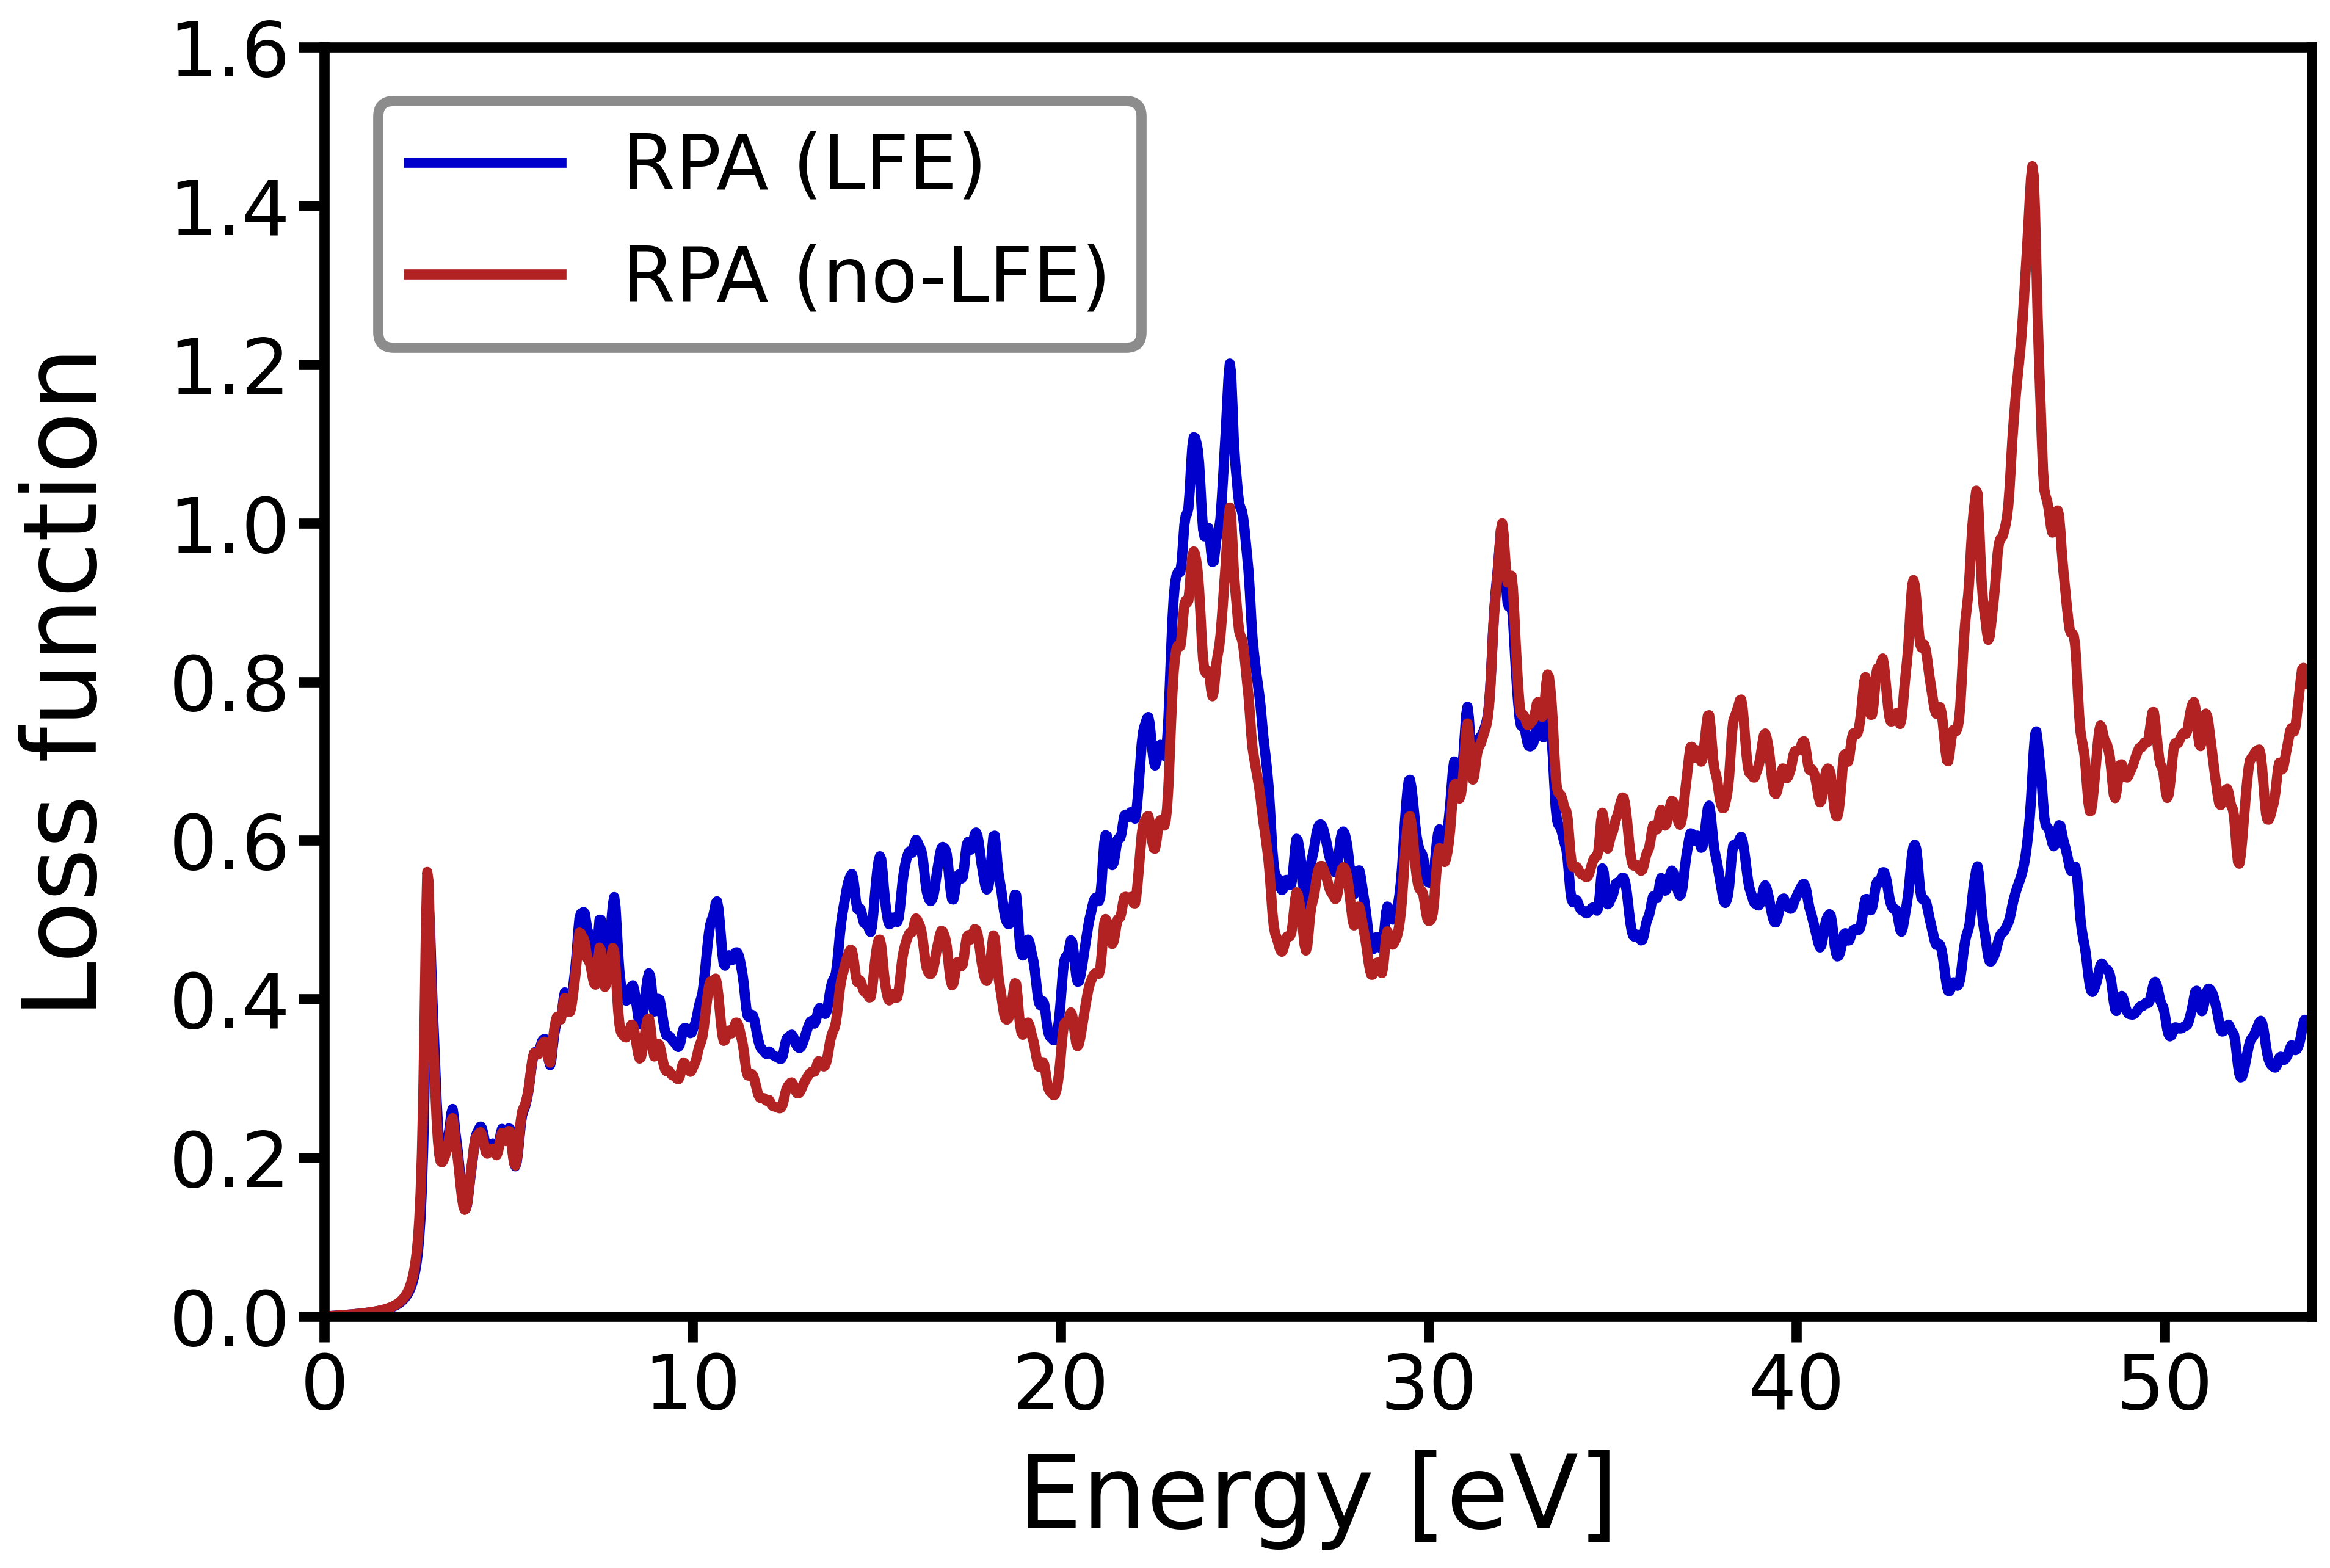" width="500" align="left"/>
</figure>

As can be seen, the impact of local-field effects is negligible below 8 eV. In contrast, their inclusion is important especially for energies above 35 eV, where they lead to a drastical reduction in spectral weight.

**<span style="color:#15317E">The Effect of Intraband Contributions</span>**

Now, move to the parent directory, create here a new directory, e.g., named **q001_test_2**, and copy the files **input.xml**, **EFERMI.OUT**, and **STATE.OUT** from **q001_test_1** into it.

In [9]:
%%bash
cd run_Ag_q_tddft
mkdir -p q001_test_2
cp q001_test_1/{input.xml,EFERMI.OUT,STATE.OUT} q001_test_2
cd ..

In order to calculate the loss function neglecting intraband contributions you have to change inside the file input.xml the <code><span style="color:mediumblue">intraband</span></code> attribute from <code><span style="color:firebrick">"true"</span></code> to <code><span style="color:firebrick">"false"</span></code>.

In [10]:
parsed_input = ExcitingInputXML.from_xml('./run_Ag_q_tddft/q001_test_2/input.xml')

parsed_input.xs.tddft.intraband = "false"

parsed_input.write('./run_Ag_q_tddft/q001_test_2/input.xml')

Then, start the calculation. 

In [11]:
%%bash
cd run_Ag_q_tddft
python3 -m excitingscripts.execute.single -r q001_test_2
cd ..

After the calculation finished successfully, you can plot the loss functions neglecting and including intraband contributions for comparison. In order to do so, use the following commands:

In [17]:
%%bash
cd run_Ag_q_tddft/q001_test_2
cp LOSS_FXCRPA_QMT002.OUT no-intraband_toplot_LOSS_FXCRPA_QMT002.OUT
cp ../q001_test_1/LOSS_FXCRPA_QMT002.OUT intraband_toplot_LOSS_FXCRPA_QMT002.OUT
python3 -m excitingscripts.plot.files -f no-intraband_toplot_LOSS_FXCRPA_QMT002.OUT intraband_toplot_LOSS_FXCRPA_QMT002.OUT -lx 'Energy [eV]'  -ly 'Loss function'  -x 0 54  -y 0 1.6 -ll 'no-intraband RPA (LFE)' 'intraband RPA (LFE)'
cd ../..

You should obtain the following result:

<figure>
<img src=" 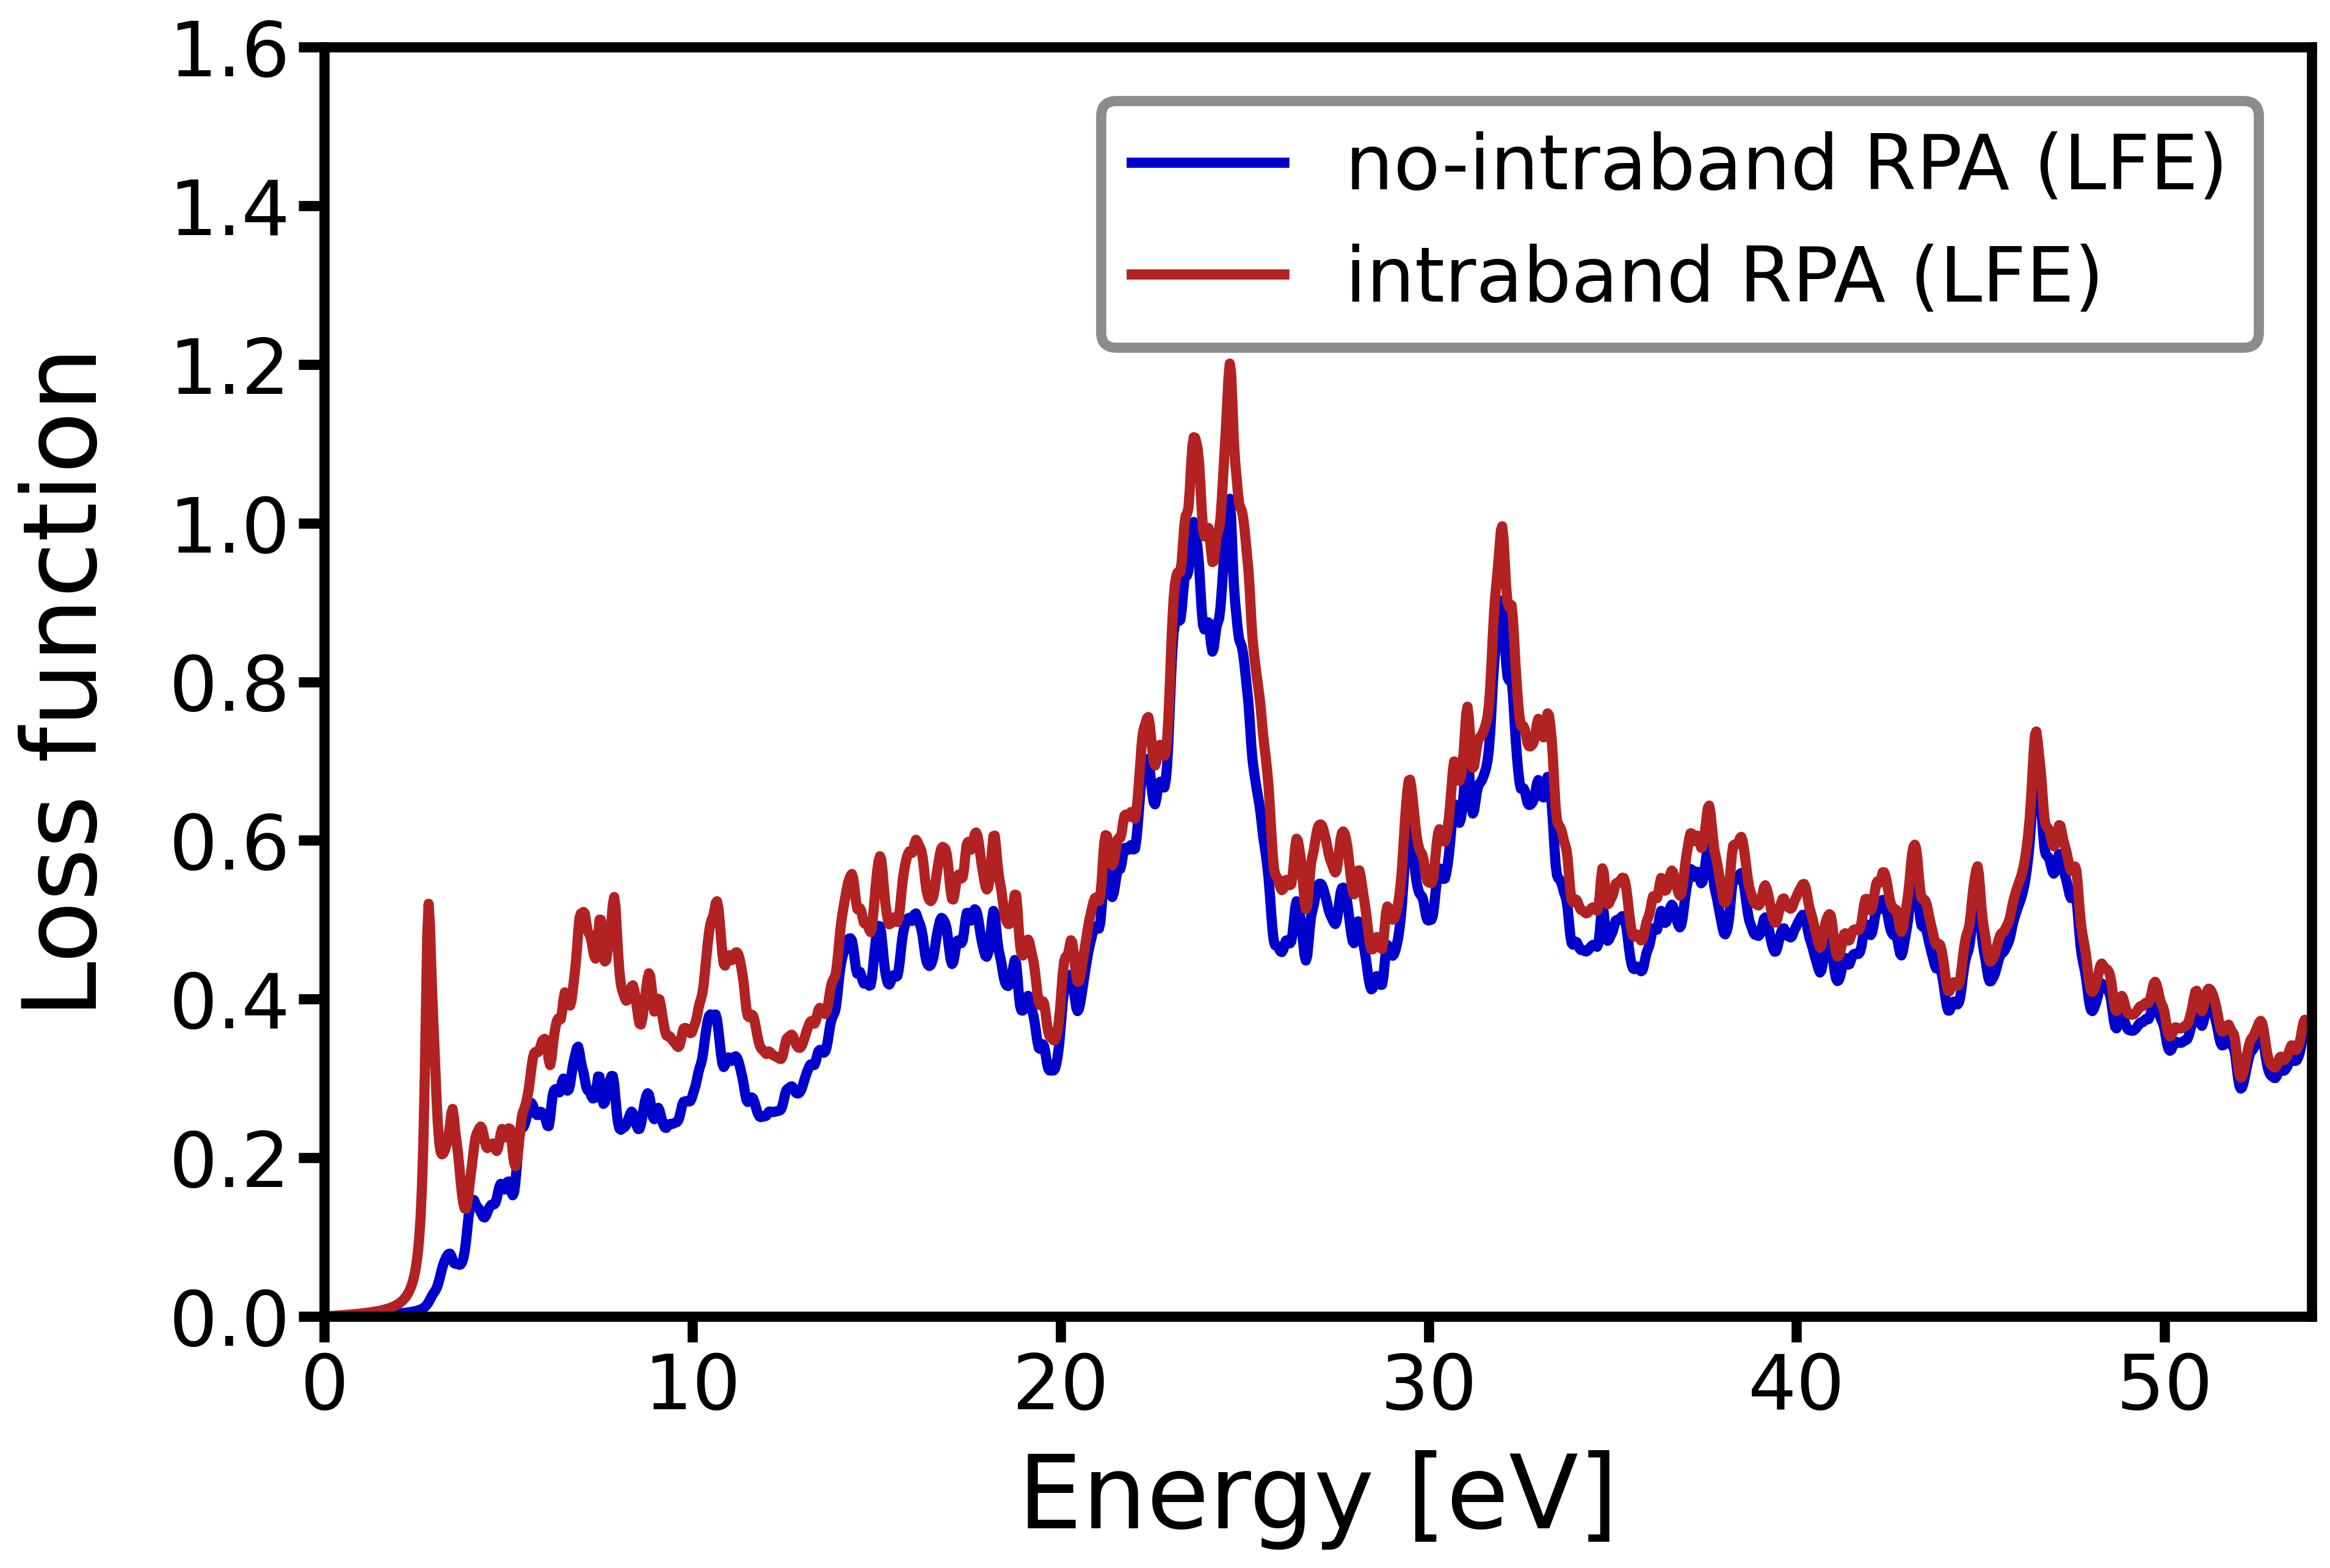" width="500" align="left"/>
</figure>

As visible from the figure, the inclusion of intraband contributions increases the spectral weight and gives rise to a sharp plasmon peak around 3 eV.

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. Converging the Results</span>

Before starting a series of calculations to investigate the **q** dependence of different optical quantities, it is necessary to find a proper set of parameters leading to high-quality spectra. The choice of the parameters listed below is crucial for the accuracy of the calculation.

Attribute | Element | Description
:--- | :--- | :---
<code><span style="color:mediumblue">ngridk</span></code> | <code><span style="color:green">xs</span></code> | The quality of the spectra depends on the size of the **k**-mesh. A denser **k**-mesh results in a better resolution of the spectrum. Thus, always check for convergence with respect to the number of **k** points. The <code><span style="color:mediumblue">ngridk</span></code> attribute inside the <code><span style="color:green">xs</span></code> element is independent of the <code><span style="color:mediumblue">ngridk</span></code> inside the <code><span style="color:green">groundstate</span></code> element
<code><span style="color:mediumblue">swidth</span></code> | <code><span style="color:green">xs</span></code> | In particular for metals, the convergence test with respect to the smearing width <code><span style="color:mediumblue">swidth</span></code> must go hand in hand with that of <code><span style="color:mediumblue">ngridk</span></code>.
<code><span style="color:mediumblue">rgkmax</span></code> | <code><span style="color:green">xs</span></code> | It determines the size of the basis set and, therefore, influences the quality of the eigenvalues. When increasing it, the computational time rises rapidly. The <code><span style="color:mediumblue">rgkmax</span></code> attribute inside the <code><span style="color:green">xs</span></code> element is independent of the <code><span style="color:mediumblue">rgkmax</span></code> inside the <code><span style="color:green">groundstate</span></code> element. 
<code><span style="color:mediumblue">gqmax</span></code> | <code><span style="color:green">xs</span></code> | This is the value of the local-field effects cutoff **<span style="color:firebrick">G<sub>max</sub></span>**. If it is set to zero, local-field effects are neglected.
<code><span style="color:mediumblue">nempty</span></code> | <code><span style="color:green">xs</span></code> | It determines the number of empty states considered in the calculation and depends on the energy range of interest.  In some case, a larger value of <code><span style="color:mediumblue">gqmax</span></code> may require a larger value for <code><span style="color:mediumblue">nempty</span></code>. Thus, you always have to converge with respect to <code><span style="color:mediumblue">nempty</span></code> after selecting a new <code><span style="color:mediumblue">gqmax</span></code>.

For further information see **[<span style="color:firebrick">Input Reference</span>](https://www.exciting-code.org/home/about/input-reference)** and the tutorial **Excited states from TDDFT**.

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">6. Evolution of the Electron Energy-Loss Function for Increasing Momentum Transfer</span>

To study the evolution of optical spectra with increasing momentum transfer in a certain direction within the Brillouin Zone, you have the following two possibilities:

1. Repeat the procedure discussed in **Section 2** several times and change the **q** point in **input.xml** after every run. In this case it is necessary to save the output files with a new name, otherwise the results will be overwritten by the next calculation.
2. List the **q** points inside the <code><span style="color:green">qpointset</span></code> element using the <code><span style="color:green">qpoint</span></code> element. In this case, the calculation produces a set of output files for each **q** point. The output files can be related to the **q** points with the help of the **QPOINTS.OUT** file and the number following the **QMT** label.

Move to the parent directory. Create a new directory with the name **q001_test_3** and copy the **input.xml**, **EFERMI.OUT**, and the **STATE.OUT** files into it.

In [14]:
%%bash
cd run_Ag_q_tddft
mkdir -p q001_test_3
cp q001_test_1/{input.xml,EFERMI.OUT,STATE.OUT} q001_test_3
cd ..

We will use the second approach to study the momentum dependence along the (001) direction. For this purpose, replace the <code><span style="color:green">qpointset</span></code> element in **input.xml** by

```xml
...
      <qpointset>
         <qpoint> 0.0 0.0 0.00 </qpoint> 
         <qpoint> 0.0 0.0 0.03 </qpoint>                       
         <qpoint> 0.0 0.0 0.06 </qpoint>                     
         <qpoint> 0.0 0.0 0.09 </qpoint>
      </qpointset>
...
```

To reduce the computing time for this test calculation, neglect local-field effects by setting <code><span style="color:mediumblue">gqmax</span>=<span style="color:firebrick">"0.0"</span></code>, set <code><span style="color:mediumblue">nempty</span>=<span style="color:firebrick">"10"</span></code> and change the <code><span style="color:mediumblue">intv</span></code> attribute to <code><span style="color:firebrick">"0.0 0.3"</span></code>. Intraband contributions should be included in the calculation.

In [15]:
# The following lines modify the input.xml using Python
parsed_input = ExcitingInputXML.from_xml('./run_Ag_q_tddft/q001_test_3/input.xml')

xs = {'xstype': 'TDDFT',
      'ngridk': [8, 8, 8],
      'vkloff': [0.097, 0.273, 0.493],
      'nempty': 10,
      'gqmax': 0.0,
      'broad': 0.004,
      'tevout': True,
      'energywindow': {'intv': [0.0, 3.0], 'points': 1500},
      'tddft': {'fxctype': 'RPA', 'intraband': True},
      'qpointset': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.03], [0.0, 0.0, 0.06], [0.0, 0.0, 0.09]]}

parsed_input.xs = ExcitingXSInput(**xs)

parsed_input.write('./run_Ag_q_tddft/q001_test_3/input.xml')

Now, start the **TDDFT** calculation

In [16]:
%%bash
cd run_Ag_q_tddft
python3 -m excitingscripts.execute.single -r q001_test_3
cd ..

and, through the file **INFOXS.OUT**, monitor its progress.

In order to visualize your results, you can use the script **`excitingscripts.plot.files`** as follows:

In [17]:
%%bash
cd run_Ag_q_tddft/q001_test_3
python3 -m excitingscripts.plot.files -f LOSS_NLF_FXCRPA_QMT002.OUT LOSS_NLF_FXCRPA_QMT003.OUT LOSS_NLF_FXCRPA_QMT004.OUT -lx 'Energy [eV]'  -ly 'Loss function'  -x 0 8  -y 0 1.2 -ll 'QMT002' 'QMT003' 'QMT004'
cd ../..

With this command, you will create a plot like the one below.

<figure>
<img src=" 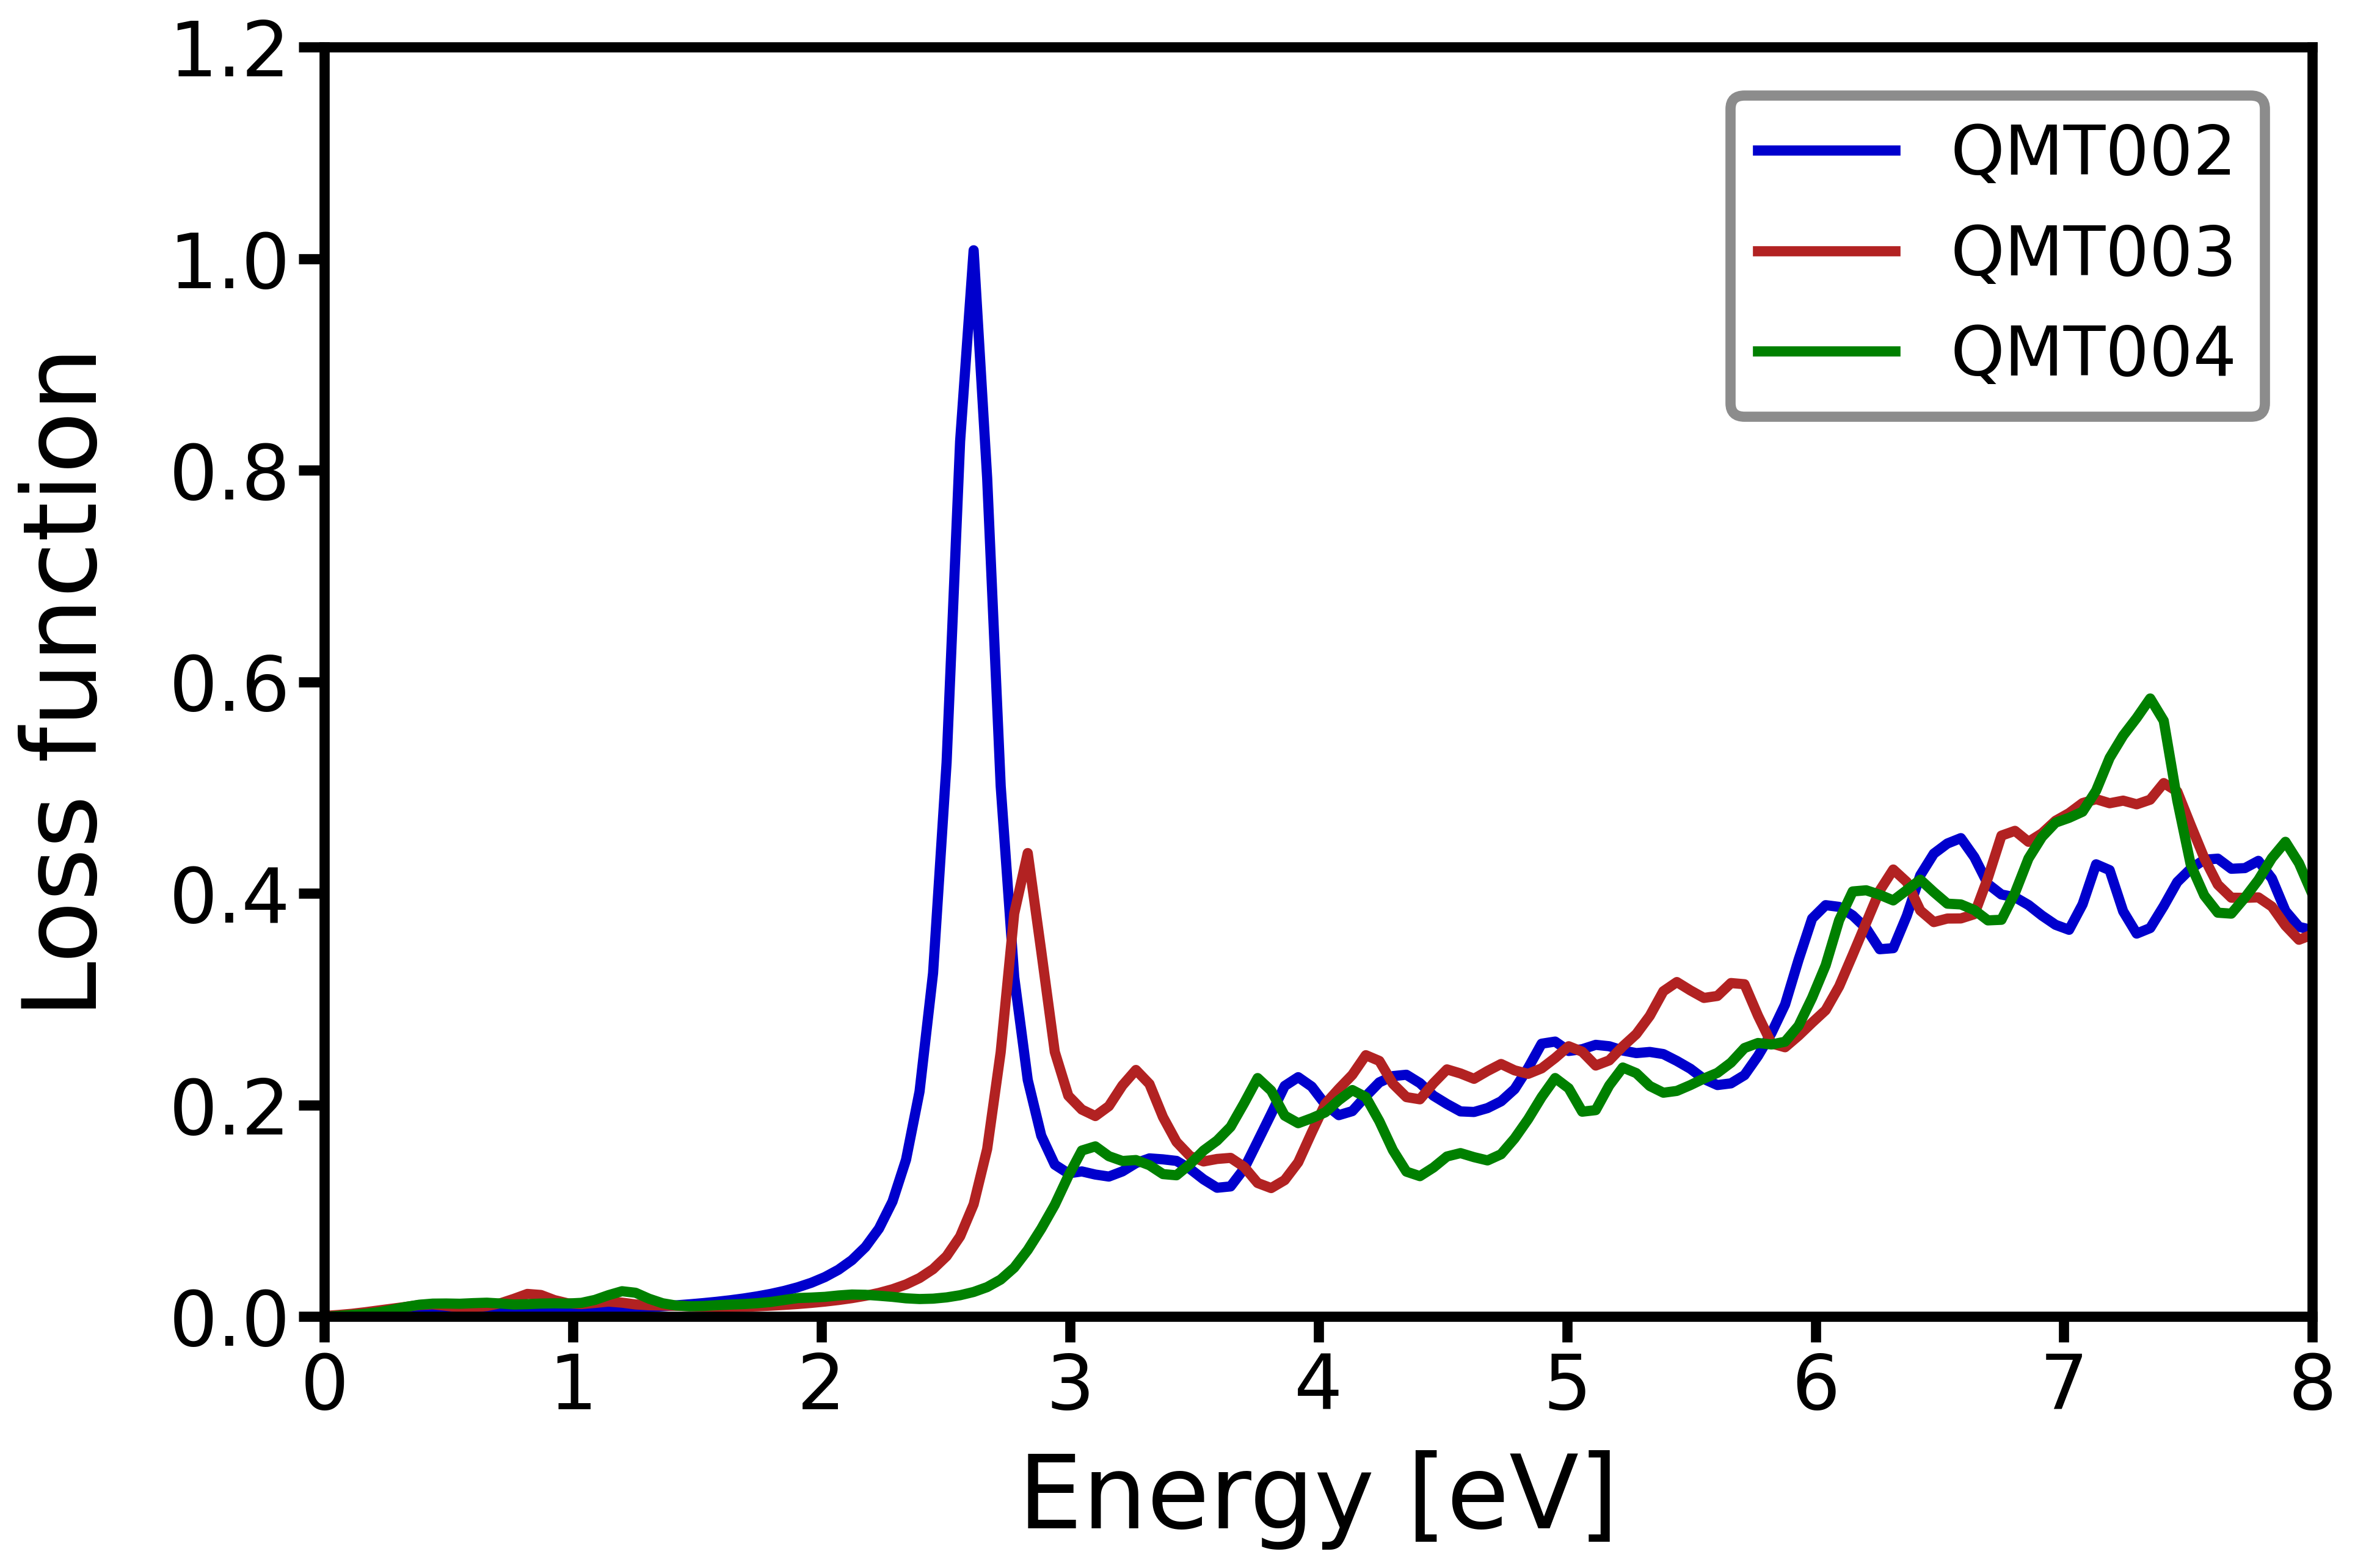" width="500" align="left"/>
</figure>

<a id='6.1'></a>
The main change in the spectrum with increasing momentum transfer occurs at the onset of the spectrum, where the plasmonic peak moves to higher energies and concurrently loses intensity. The features at higher energies show no dispersion.

**<span style="color:firebrick">Note</span>**: A realistic investigation of the evolution of the low-energy plasmon with increasing momentum transfer requires a much denser **k** mesh than that used in this example.

**<span style="color:green">Exercise</span>**
- Set up and perform similar calculations for increasing momentum transfer in (011) or (111) direction. Visualize the results.

<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Bibliography</span>

1. Tutorial talk by Stefan Sagmeister (**[PDF](http://exciting.wdfiles.com/local--files/boron-excited-states-from-tddft/cecam-tddft.pdf)**) at the **HoW exciting! 2010** workshop in Lausanne.
2. Further information on the momentum-dependent loss function of Ag: A. Alkauskas, S. Schneider, S. Sagmeister, C. Ambrosch-Draxl, and C. Hèbert, *Theoretical analysis of the momentum-dependent loss function of bulk Ag*, Ultramicroscopy **110**, 1081 (2010) (**[PDF](https://www.sciencedirect.com/science/article/pii/S0304399109002745?via%3Dihub)**).
3. More details on the implementation of the **TDDFT** formalism within the **LAPW** method: S. Sagmeister, PhD thesis, University of Graz, August 2009 (**[PDF](https://unipub.uni-graz.at/obvugrhs/download/pdf/208046?originalFilename=true)**).

<hr style="border:2px solid #DDD"> </hr>